In [1]:
!pip install contractions
import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer
import seaborn as sns
import unicodedata
import contractions
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score,KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import roc_curve
from sklearn.model_selection import learning_curve
import warnings
import pickle
warnings.filterwarnings('ignore')
%matplotlib inline

     |████████████████████████████████| 287 kB 6.7 MB/s 
     |████████████████████████████████| 106 kB 49.9 MB/s 


**DATA ACQUISITION**

In [2]:
! pip install kaggle

In [3]:
! mkdir ~/.kaggle

In [4]:
! cp kaggle.json ~/.kaggle/

In [5]:
! chmod 600 ~/.kaggle/kaggle.json

In [6]:
! kaggle datasets download "kazanova/sentiment140"

 77% 62.0M/80.9M [00:00<00:00, 175MB/s]
100% 80.9M/80.9M [00:00<00:00, 163MB/s]


In [7]:
! unzip "sentiment140"

Archive:  sentiment140.zip
  inflating: training.1600000.processed.noemoticon.csv  


In [8]:
depressed_1 = pd.read_csv('Suicide.csv',encoding='ISO-8859-1')
depressed_2 = pd.read_csv('Lonely.csv',encoding='ISO-8859-1')
depressed_3 = pd.read_csv('Hopeless.csv',encoding='ISO-8859-1')
depressed_4 = pd.read_csv('Depression.csv',encoding='ISO-8859-1')
depressed_5 = pd.read_csv('Depressed.csv',encoding='ISO-8859-1')
depressed_6 = pd.read_csv('Antidepressant.csv',encoding='ISO-8859-1')

col_names = ['target', 'id', 'date', 'flag', 'user', 'text']
non_depressed_1 = pd.read_csv('training.1600000.processed.noemoticon.csv',encoding='ISO-8859-1',names=col_names)

In [9]:
depressed_1.drop(['conversation_id', 'created_at', 'date', 'time', 'timezone', 'user_id', 'username', 'name', 'place', 'mentions', 'urls', 'photos', 'replies_count', 'retweets_count', 'likes_count', 'hashtags', 
      'cashtags', 'link', 'retweet', 'quote_url', 'video', 'user_rt_id', 'near', 'geo'], axis = 1,inplace = True)
depressed_2.drop(['conversation_id', 'created_at', 'date', 'time', 'timezone', 'user_id', 'username', 'name', 'place', 'mentions', 'urls', 'photos', 'replies_count', 'retweets_count', 'likes_count', 'hashtags', 
      'cashtags', 'link', 'retweet', 'quote_url', 'video', 'user_rt_id', 'near', 'geo'], axis = 1,inplace = True)
depressed_3.drop(['conversation_id', 'created_at', 'date', 'time', 'timezone', 'user_id', 'username', 'name', 'place', 'mentions', 'urls', 'photos', 'replies_count', 'retweets_count', 'likes_count', 'hashtags', 
      'cashtags', 'link', 'retweet', 'quote_url', 'video', 'user_rt_id', 'near', 'geo'], axis = 1,inplace = True)
depressed_4.drop(['time', 'hashtags', 'cashtags', 'Unnamed: 0'], axis = 1,inplace = True)
depressed_5.drop(['conversation_id', 'created_at', 'date', 'time', 'timezone', 'user_id', 'username', 'name', 'place', 'mentions', 'urls', 'photos', 'replies_count', 'retweets_count', 'likes_count', 'hashtags', 
      'cashtags', 'link', 'retweet', 'quote_url', 'video', 'user_rt_id', 'near', 'geo'], axis = 1,inplace = True)
depressed_6.drop(['conversation_id', 'created_at', 'date', 'time', 'timezone', 'user_id', 'username', 'name', 'place', 'mentions', 'urls', 'photos', 'replies_count', 'retweets_count', 'likes_count', 'hashtags', 
      'cashtags', 'link', 'retweet', 'quote_url', 'video', 'user_rt_id', 'near', 'geo'], axis = 1,inplace = True)
non_depressed_1.drop(['date', 'flag', 'user'], axis = 1,inplace = True)

In [10]:
depressed_1.shape, depressed_2.shape, depressed_3.shape, depressed_4.shape, depressed_5.shape, depressed_6.shape

((25128, 2), (53772, 2), (9021, 2), (135497, 2), (20932, 2), (883, 2))

In [11]:
df1 = depressed_1.copy().sample(2000, random_state=42)
df1["label"] = 1
df2 = depressed_2.copy().sample(2000, random_state=42)
df2["label"] = 1
df3 = depressed_3.copy().sample(2000, random_state=42)
df3["label"] = 1
df4 = depressed_4.copy().sample(2000, random_state=42)
df4["label"] = 1
df5 = depressed_5.copy().sample(2000, random_state=42)
df5["label"] = 1
df6 = depressed_6.copy()
df6["label"] = 1

non_depressed_1 = non_depressed_1[non_depressed_1['target']==4]
df7 = non_depressed_1.copy().sample(8000, random_state=42)
df7["label"] = 0
df7 = df7[['id','text', 'label']]
df7.rename(columns = {'text':'tweet'},inplace=True)

In [12]:
frames = [df1, df2, df3, df4, df5, df6, df7]
final_data = pd.concat(frames)
final_data = final_data.sample(frac = 1, random_state = 42)
final_data.reset_index(inplace=True)
final_data.drop(['index'],axis=1,inplace=True)
display(final_data)

,id,tweet,label
0,1152661967120687104,one my high school friends from band died by s...,1
1,1151425095035809792,@TheOfficialSBI Even after visiting the branch...,1
2,1152736788659748864,What does being emotional has to so with commo...,1
3,2001731580,"is at the shopping mall, ready to spend some q...",0
4,1.1526E+18,Faruk iyi misin..ðð neyse sen iÅe gidiy...,1
...,...,...,...
18878,1992831885,"@ChicMom well, good luck!",0
18879,1557765410,"@AmyriadfthINGs yeah, that was a first for me ...",0
18880,1151304500671442944,Sering terjadi ketika hopeless dengan pekerjaa...,1
18881,1152844042729689093,These last few months have been the absolutely...,1


In [13]:
final_data.to_csv('ML_Dataset.csv',index=False)

**PREPROCESSING**

In [14]:
print("Dimensions of our Dataset: ", final_data.shape)
print("\n")

print("Datset Info: \n")
final_data.info()

Dimensions of our Dataset:  (18883, 3)


Datset Info: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18883 entries, 0 to 18882
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      18883 non-null  object
 1   tweet   18883 non-null  object
 2   label   18883 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 442.7+ KB


In [15]:
print("\033[1m" + "Null Values" + "\033[0m\n")
print(final_data.isnull().sum(), "\n")
print("\033[1m" + "______________________________________________________________________________" + "\033[0m\n")
print("\033[1m" + "Duplicate Values" + "\033[0m\n")
display(final_data[final_data.duplicated(keep=False)])
final_data.drop_duplicates(inplace = True)
final_data.reset_index(inplace=True)
final_data.drop(['index'],axis=1,inplace=True)
print("\n\033[1m" + "New DataSet Shape" + "\033[0m\n")
final_data.shape

Null Values

id       0
tweet    0
label    0
dtype: int64 

______________________________________________________________________________

Duplicate Values



,id,tweet,label
896,1152747296938815488,"The question by itself, no. However are you ...",1
1693,1152630351631716353,Of course they are useful. It's their overuse ...,1
2549,1152630351631716353,Of course they are useful. It's their overuse ...,1
8426,1152962786542202885,Antidepressants increase suicide risk by 2.5x ...,1
16455,1152747296938815488,"The question by itself, no. However are you ...",1
17115,1152962786542202885,Antidepressants increase suicide risk by 2.5x ...,1



New DataSet Shape



(18880, 3)

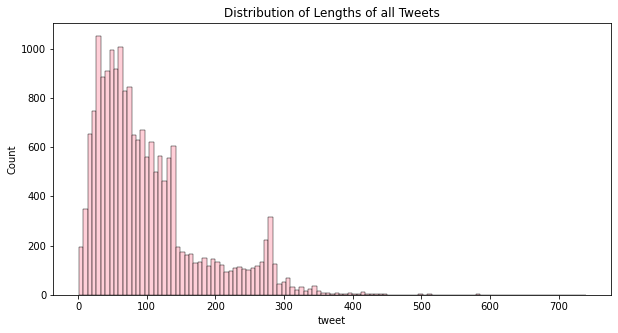

In [16]:
tweet_length = final_data["tweet"].apply(len)
plt.figure(figsize=(10,5))
sns.histplot(tweet_length, color='pink')
plt.title("Distribution of Lengths of all Tweets")
plt.show()

Number of tweets for each depressive and non depressive category: 
 Depressive        10880
Non-Depressive     8000
Name: label, dtype: int64




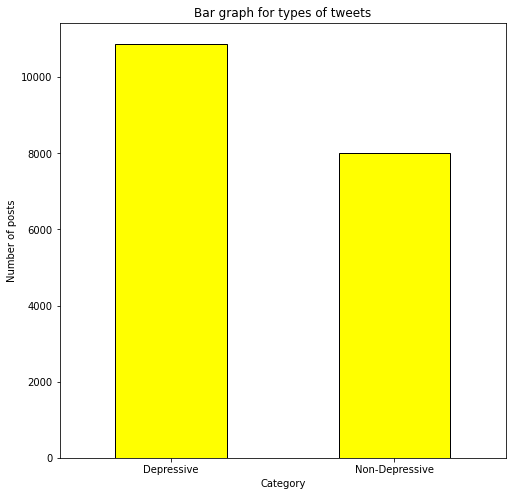

In [17]:
Counts=final_data.label.value_counts()
Counts.rename(index={0: 'Non-Depressive', 1: 'Depressive'}, inplace=True)
print("Number of tweets for each depressive and non depressive category: \n", Counts)
print("\n")
Counts.plot(kind='bar', figsize=(8,8), ylabel='Number of posts', xlabel='Category', title='Bar graph for types of tweets', color='yellow', edgecolor = 'black')
plt.xticks(rotation=360)
plt.show()

In [18]:
final_data.drop(['id'], axis=1, inplace = True)
data_before_preprocessing = final_data.copy(deep=True)

In [19]:
# Removing URL links from texts.
for i in range(final_data.shape[0]):
  processed_tweet_1 = re.sub(r"http\S+",' ', final_data._get_value(i, 'tweet'))
  final_data._set_value(i, 'tweet', processed_tweet_1)

# Removing non-ascii-characters.
for i in range(final_data.shape[0]):
  t = final_data._get_value(i, 'tweet')
  t = [w for w in t.split(' ')]
  new_words = []
  for word in t:
          new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
          new_words.append(new_word)
  t = " ".join(new_words)
  final_data._set_value(i, 'tweet', t)

# Expanding Contractions
for i in range(final_data.shape[0]):
  tweet = final_data._get_value(i, 'tweet')
  expanded_tweet = contractions.fix(tweet)
  final_data._set_value(i, 'tweet', expanded_tweet)

# Converting to lower case
final_data["tweet"] = final_data["tweet"].str.lower()

# Removing @ mentions from the tweets.
for i in range(final_data.shape[0]):
  tweet = final_data._get_value(i, 'tweet')
  clean_tweet = re.sub("@[A-Za-z0-9_]+","", tweet)
  final_data._set_value(i, 'tweet', clean_tweet)

#removing special characters and numbers from texts.
for i in range(final_data.shape[0]):
  t = final_data._get_value(i, 'tweet')
  p = re.compile('\W+')
  t = re.sub(p, ' ', t)
  p = re.compile(r'[0-9]')
  t = re.sub(p, ' ', t)
  p = re.compile(r'[_+]')
  t = re.sub(p, ' ', t)
  final_data._set_value(i, 'tweet',t)

# Removing extra space
for i in range(final_data.shape[0]):
  t = final_data._get_value(i, 'tweet')
  p = re.compile('\s+')
  t = re.sub(p, ' ', t)
  final_data._set_value(i, 'tweet', t)

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

# remove stop words
remove_words = stopwords.words("english")
for i in range(final_data.shape[0]):
  t = final_data._get_value(i, 'tweet')
  t = " ".join([w for w in t.split(' ') if w not in remove_words])
  final_data._set_value(i, 'tweet', t)

#Lemmatization (grouping similar words)
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
nltk.download('wordnet')
for i in range(final_data.shape[0]):
  t = final_data._get_value(i, 'tweet')
  t = " ".join([lemmatizer.lemmatize(w) for w in t.split(' ')])
  final_data._set_value(i, 'tweet', t)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [20]:
print("Text before preprocessing :", data_before_preprocessing.iloc[89,0], "\n")
print("Text after preprocessing :", final_data.iloc[89,0], "\n")

Text before preprocessing : We have a library but I donât read much and itâs in my backyard right by the middle school always full of middle school children. Not really my kind of age group ð 

Text after preprocessing : library donat read much itas backyard right middle school always full middle school child really kind age group  



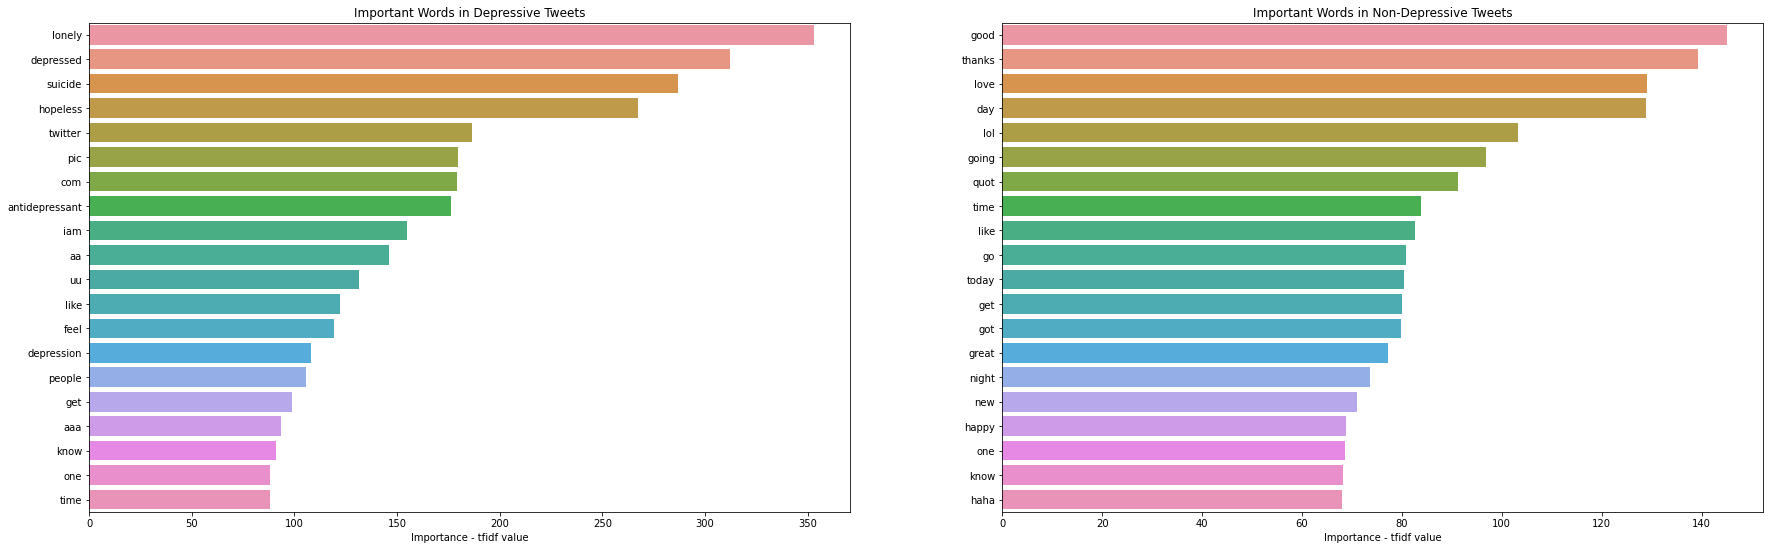

In [21]:
def imp_words(relevant_data, data):
    vec = TfidfVectorizer().fit(data)
    bag_of_words = vec.transform(relevant_data)
    words_sum = bag_of_words.sum(axis=0) 
    words_freq = [(word, words_sum[0, idx]) for word, idx in vec.vocabulary_.items()]
    imp_words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    imp_words_freq = imp_words_freq[:20]
    return imp_words_freq

depressive_data = final_data[final_data['label'] == 1]
imp_depressive_words = imp_words(depressive_data['tweet'], final_data['tweet'])

plt.figure(figsize=(30,9))
plt.subplot(1, 2, 1)
words = [x[0] for x in imp_depressive_words]
imp = [x[1] for x in imp_depressive_words]
sns.barplot(x = imp, y = words)
plt.xlabel('Importance - tfidf value')
plt.title('Important Words in Depressive Tweets')

non_depressive_data = final_data[final_data['label'] == 0]
imp_non_depressive_words = imp_words(non_depressive_data['tweet'], final_data['tweet'])

plt.subplot(1, 2, 2)
words = [x[0] for x in imp_non_depressive_words]
imp = [x[1] for x in imp_non_depressive_words]
sns.barplot(x = imp, y = words)
plt.xlabel('Importance - tfidf value')
plt.title('Important Words in Non-Depressive Tweets')
plt.savefig('bar.png')
plt.show()

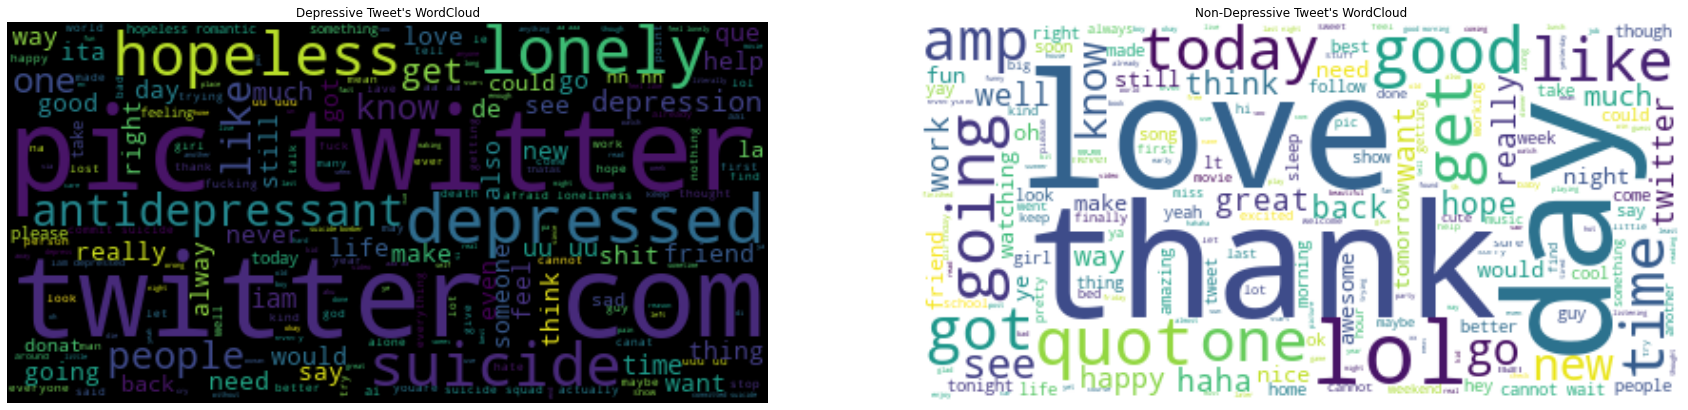

In [22]:
depressive_data= final_data[final_data['label']==1]
tweets = " ".join(depressive_data['tweet'].tolist())
wordcount=WordCloud(background_color="black", max_words=200, contour_width=3, stopwords=remove_words)
wordcount.generate(tweets)
plt.figure(figsize=(30,10))
plt.subplot(1, 2, 1)
plt.axis("off")
plt.title("Depressive Tweet's WordCloud")
plt.imshow(wordcount, interpolation='bilinear')

print()

non_depressive_data= final_data[final_data['label']==0]
tweets = " ".join(non_depressive_data['tweet'].tolist())
wordcount=WordCloud(background_color="white", max_words=200, contour_width=3, stopwords=remove_words)
wordcount.generate(tweets)
plt.subplot(1, 2, 2)
plt.axis("off")
plt.title("Non-Depressive Tweet's WordCloud")
plt.imshow(wordcount, interpolation='bilinear')
plt.savefig('word_cloud.png')
plt.show()

**Feature Extraction**

In [23]:
frequency = final_data.tweet.str.split(expand = True).stack().value_counts()
relevant_words = frequency[frequency.values >= 10]
relevant_words

suicide       1923
depressed     1503
lonely        1491
twitter       1354
hopeless      1300
              ... 
aaac            10
bloody          10
collection      10
musical         10
hace            10
Length: 2342, dtype: int64

In [24]:
tweet_list = final_data.tweet.to_list()
vec = CountVectorizer(stop_words='english', max_features= len(relevant_words))
features = vec.fit_transform(tweet_list)
transformer = TfidfTransformer()
final_features =  transformer.fit_transform(features).toarray()
X = pd.DataFrame(final_features)
y = final_data['label']

**Train - Test Split**

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((16992, 2342), (1888, 2342), (16992,), (1888,))

**LEARNING TECHNIQUES**

**Baseline model -** LOGISTIC REGRESSION

In [26]:
# Logistic regression
a = LogisticRegression(penalty="none", max_iter = 1000, C = 1, solver="lbfgs")
kf = KFold(n_splits=10, random_state = 42, shuffle = True)
score = cross_val_score(a, X_train, y_train, cv=kf, scoring='accuracy')
print("Cross Validation Scores are {}".format(score))
print("Average Cross Validation score :{}".format(score.mean()))

Cross Validation Scores are [0.89058824 0.89823529 0.8852266  0.90052972 0.87992937 0.88346086
 0.87698646 0.87875221 0.89405533 0.891701  ]
Average Cross Validation score :0.8879465083266973


In [27]:
C = np.logspace(-3,3,7)
penalty = ["l1","l2"]
solver = ["liblinear"]
max_iter = [100, 500, 1000, 1500]

'''param_grid = dict(C=C, penalty = penalty, solver = solver, max_iter = max_iter)'''

param_grid = dict(C=C, penalty = penalty, solver = solver, max_iter = max_iter)
classifier = LogisticRegression(C=C, penalty = penalty, solver = solver, max_iter = max_iter)
grid = GridSearchCV(estimator=classifier, param_grid=param_grid, cv = 5)
results = grid.fit(X_train, y_train)

# Summarize the results in a readable format
print("Best: {0}, using {1}".format(results.cv_results_['mean_test_score'].max(), results.best_params_))
df_log_reg = pd.DataFrame(results.cv_results_)
df_log_reg

Best: 0.9179613468698424, using {'C': 10.0, 'max_iter': 100, 'penalty': 'l2', 'solver': 'liblinear'}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_max_iter,param_penalty,param_solver,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.265716,0.010514,0.028824,0.001176,0.001,100,l1,liblinear,"{'C': 0.001, 'max_iter': 100, 'penalty': 'l1',...",0.576052,0.576052,0.576221,0.575927,0.575927,0.576036,0.000108,45
1,0.265664,0.003466,0.030100,0.003227,0.001,100,l2,liblinear,"{'C': 0.001, 'max_iter': 100, 'penalty': 'l2',...",0.576052,0.576052,0.576221,0.575927,0.575927,0.576036,0.000108,45
2,0.263534,0.000699,0.029029,0.000860,0.001,500,l1,liblinear,"{'C': 0.001, 'max_iter': 500, 'penalty': 'l1',...",0.576052,0.576052,0.576221,0.575927,0.575927,0.576036,0.000108,45
3,0.268244,0.004436,0.029146,0.000851,0.001,500,l2,liblinear,"{'C': 0.001, 'max_iter': 500, 'penalty': 'l2',...",0.576052,0.576052,0.576221,0.575927,0.575927,0.576036,0.000108,45
4,0.268338,0.016603,0.029294,0.001629,0.001,1000,l1,liblinear,"{'C': 0.001, 'max_iter': 1000, 'penalty': 'l1'...",0.576052,0.576052,0.576221,0.575927,0.575927,0.576036,0.000108,45
5,0.270140,0.004922,0.028346,0.000570,0.001,1000,l2,liblinear,"{'C': 0.001, 'max_iter': 1000, 'penalty': 'l2'...",0.576052,0.576052,0.576221,0.575927,0.575927,0.576036,0.000108,45
6,0.258818,0.002202,0.030485,0.003207,0.001,1500,l1,liblinear,"{'C': 0.001, 'max_iter': 1500, 'penalty': 'l1'...",0.576052,0.576052,0.576221,0.575927,0.575927,0.576036,0.000108,45
7,0.265753,0.001386,0.029613,0.001787,0.001,1500,l2,liblinear,"{'C': 0.001, 'max_iter': 1500, 'penalty': 'l2'...",0.576052,0.576052,0.576221,0.575927,0.575927,0.576036,0.000108,45
8,0.268755,0.005886,0.029336,0.001041,0.01,100,l1,liblinear,"{'C': 0.01, 'max_iter': 100, 'penalty': 'l1', ...",0.576052,0.576052,0.576221,0.575927,0.575927,0.576036,0.000108,45
9,0.269374,0.005283,0.031212,0.002633,0.01,100,l2,liblinear,"{'C': 0.01, 'max_iter': 100, 'penalty': 'l2', ...",0.673139,0.662548,0.668629,0.670983,0.674514,0.669963,0.004210,41


Cross Validation Scores are [0.91294118 0.92235294 0.92760447 0.92466157 0.91701001 0.91995291
 0.92171866 0.90935845 0.91642142 0.92642731]
Average Cross Validation score :0.9198448914586435

Performance on Test Set

              precision    recall  f1-score   support

           0       0.89      0.90      0.89       796
           1       0.92      0.92      0.92      1092

    accuracy                           0.91      1888
   macro avg       0.91      0.91      0.91      1888
weighted avg       0.91      0.91      0.91      1888





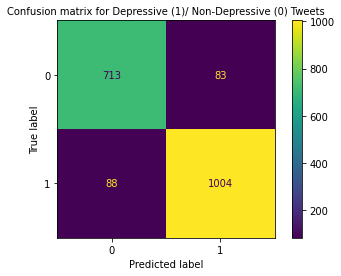

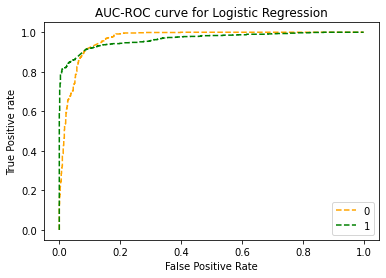

In [28]:
model = LogisticRegression(C = 10.0, max_iter = 100, penalty = 'l2', solver = 'liblinear')
kf = KFold(n_splits=10, random_state = 42, shuffle = True)
score = cross_val_score(model, X_train, y_train, cv=kf, scoring='accuracy')
print("Cross Validation Scores are {}".format(score))
print("Average Cross Validation score :{}".format(score.mean()))

# Classification Report
print("\n\033[1m"+"Performance on Test Set" + "\033[0m\n")
model.fit(X_train, y_train)
predictions = model.predict(X_test)
print(classification_report(y_test, predictions))

# Confusion Matrix
print("\n")
plot_confusion_matrix(model, X_test, y_test)  
plt.title("Confusion matrix for Depressive (1)/ Non-Depressive (0) Tweets", size = 10);
plt.savefig('lg_confusion_m.png')
plt.show()

# AUC-ROC Curve
print("\n")
fpr = {}
tpr = {}
thresh = {}
labels = model.classes_
pred_y_prob = model.predict_proba(X_test)
for i in range(2):    
  fpr[i], tpr[i], thresh[i] = roc_curve(y_test, pred_y_prob[:,i],pos_label=labels[i])
      
plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label= labels[0])
plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label= labels[1])

plt.title("AUC-ROC curve for Logistic Regression")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.show()

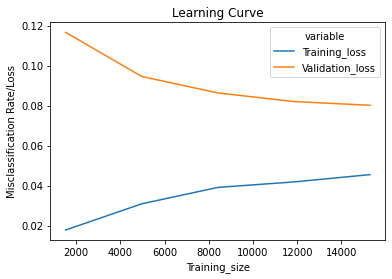

In [29]:
# Learning Curve
train_score = model.score(X_train, y_train)
train_size, train_scores, test_scores = learning_curve(estimator=model, X=X_train, y=y_train, cv=kf, scoring="accuracy", random_state=42)
test_scores = 1-np.mean(test_scores,axis=1)
train_scores = 1-np.mean(train_scores,axis=1)
lc = pd.DataFrame({"Training_size":train_size,"Training_loss":train_scores,"Validation_loss":test_scores}).melt(id_vars="Training_size")
sns.lineplot(x="Training_size", y="value", data=lc, hue="variable")
plt.title("Learning Curve")
plt.ylabel("Misclassification Rate/Loss")
plt.savefig('learning_curve.png')
plt.show()

In [30]:
pickle.dump(model, open("model_Logistic_reg.pkl", 'wb'))

In [31]:
data_before_preprocessing.rename(columns={'tweet': 'tweet before preprocessing'}, inplace = True)
error = pd.DataFrame({'Actual_Values': y_test, 'Predicted_Values': predictions})
frames = [data_before_preprocessing.loc[X_test.index, 'tweet before preprocessing'], final_data.loc[X_test.index, 'tweet'], error]
error = pd.concat(frames, axis = 1)
error_analyse = error[error["Actual_Values"]!=error["Predicted_Values"]]
error_analyse

,tweet before preprocessing,tweet,Actual_Values,Predicted_Values
6285,@CupcakeGoth I squeek,squeek,0,1
18850,Best saga ever ððð» https://twitter.co...,best saga ever,1,0
12604,I didnt attempt to make fun of you but I will ...,attempt make fun say one thing since brought u...,1,0
7360,Anyone fancy a game of footie ?,anyone fancy game footie,0,1
4291,ð: atleast they left two behind ð¦: wow ...,atleast left two behind wow brownie great,1,0
...,...,...,...,...
12858,@lexiloszer heeyy is this alexis f ?,heeyy alexis f,0,1
13985,Fuddruckers with @gcmilatzo,fuddruckers,0,1
8816,Hopes the bunnys find the carrots I left out f...,hope bunny find carrot left,0,1
5792,"One day, I will forget their name One day, I'l...",one day forget name one day forget naaaaame,1,0


In [32]:
correct = error[error["Actual_Values"]==error["Predicted_Values"]]
correct

,tweet before preprocessing,tweet,Actual_Values,Predicted_Values
344,OMG BGT final tonight... PLEASE DONT LET SUSAN...,omg bgt final tonight please let susan boyle w...,0,0
11883,i just watched a cinderella story. so freaking...,watched cinderella story freaking cute sleep t...,0,0
17992,ç ç¦ãã³ãã«ãã¨ãããã­æ©ã§ãã...,ccaa aaaa aaaaaaaa aaa aaa aaaa aaa nhk suppin,1,1
7558,Ø¹Ø§Ø±Ù Ø§ÙÙ Ø¨Ø§Ø±Ø¯Ø© ÙØ§ÙÙÙ your are...,u uu uuuu hopeless case know tb enta aref ybn...,1,1
9347,@DellyRodge lol only just that last tweet you ...,lol last tweet sent x,0,0
...,...,...,...,...
9920,Ð¿ÑÐ¾ÑÐ½ÑÐ»Ð°ÑÑ Ð¿Ð¾ÑÐ¸Ð´ÐµÐ»Ð° Ð½Ð° ÐºÑ...,n n nnn n onn n n n,1,1
14624,@andybeal guess I won't be enabling that so,guess enabling,0,0
13391,ÐÐ°) ÐÐ½Ð¸ Ð¿ÑÐµÐºÑÐ°ÑÐ½Ñ!,nonn n,1,1
7728,people who commit suicide are actually seeking...,people commit suicide actually seeking mercy,1,1


**Advanced model -** RNN

In [33]:
!pip install keras-tuner
from tensorflow import keras
import keras_tuner as kt
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from keras.layers import Dropout
import tensorflow as tf

     |████████████████████████████████| 133 kB 8.1 MB/s 


In [34]:
X_test = final_data.loc[X_test.index, 'tweet'].to_frame()
y_test = final_data.loc[y_test.index, 'label']
X_mix = final_data.loc[X_train.index, 'tweet'].to_frame()
y_mix = final_data.loc[y_train.index, 'label']
X_train, X_val, y_train, y_val = train_test_split(X_mix, y_mix, test_size = 0.1, random_state = 42)
X_train.shape, X_test.shape, X_val.shape, y_train.shape, y_test.shape, y_val.shape

((15292, 1), (1888, 1), (1700, 1), (15292,), (1888,), (1700,))

In [35]:
training_data = X_train
training_data["label"] = y_train

testing_data = X_test
testing_data["label"] = y_test

val_data = X_val
val_data["label"] = y_val

training_dataset = (tf.data.Dataset.from_tensor_slices((tf.cast(training_data['tweet'].values, tf.string),tf.cast(training_data['label'].values, tf.int32))))
testing_data = (tf.data.Dataset.from_tensor_slices((tf.cast(testing_data['tweet'].values, tf.string),tf.cast(testing_data['label'].values, tf.int32))))
val_data = (tf.data.Dataset.from_tensor_slices((tf.cast(val_data['tweet'].values, tf.string),tf.cast(val_data['label'].values, tf.int32))))

training_dataset = training_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
testing_data = testing_data.batch(32).prefetch(tf.data.AUTOTUNE)
val_data = val_data.batch(32).prefetch(tf.data.AUTOTUNE)

VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(max_tokens=VOCAB_SIZE)
encoder.adapt(training_dataset.map(lambda tweet, label: tweet))

In [36]:
def model_builder(hp):
  hp_units = hp.Int('units', min_value=16, max_value=512, step=32)
  model = tf.keras.Sequential([encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 32, mask_zero=True),
    tf.keras.layers.SimpleRNN(32),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=hp_units, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
  ])
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
  model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
              metrics=['accuracy'])
  return model

tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=20,
                     factor=3,
                     directory='my_dir',
                     project_name='intro_to_kt_hppp')

es = EarlyStopping(monitor='val_loss', patience=3, verbose=1)
tuner.search(training_dataset, epochs=50, validation_data=val_data, validation_steps=20, callbacks = [es])

best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

Trial 30 Complete [00h 01m 06s]
val_accuracy: 0.9046875238418579

Best val_accuracy So Far: 0.926562488079071
Total elapsed time: 00h 20m 03s
INFO:tensorflow:Oracle triggered exit


In [37]:
print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")


The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 368 and the optimal learning rate for the optimizer
is 0.0001.



In [38]:
model = tuner.hypermodel.build(best_hps)
history = model.fit(training_dataset, epochs=20, validation_data=val_data, validation_steps=20)

val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Epoch 1/20
478/478 [==============================] - 11s 20ms/step - loss: 0.5834 - accuracy: 0.6677 - val_loss: 0.4048 - val_accuracy: 0.8516
Epoch 2/20
478/478 [==============================] - 12s 26ms/step - loss: 0.3122 - accuracy: 0.8778 - val_loss: 0.2409 - val_accuracy: 0.8969
Epoch 3/20
478/478 [==============================] - 12s 26ms/step - loss: 0.2206 - accuracy: 0.9103 - val_loss: 0.2141 - val_accuracy: 0.9000
Epoch 4/20
478/478 [==============================] - 12s 25ms/step - loss: 0.1915 - accuracy: 0.9221 - val_loss: 0.2111 - val_accuracy: 0.9125
Epoch 5/20
478/478 [==============================] - 11s 23ms/step - loss: 0.1733 - accuracy: 0.9321 - val_loss: 0.2114 - val_accuracy: 0.9141
Epoch 6/20
478/478 [==============================] - 6s 13ms/step - loss: 0.1658 - accuracy: 0.9335 - val_loss: 0.2144 - val_accuracy: 0.9156
Epoch 7/20
478/478 [==============================] - 6s 13ms/step - loss: 0.1570 - accuracy: 0.9389 - val_loss: 0.2179 - val_accuracy: 0

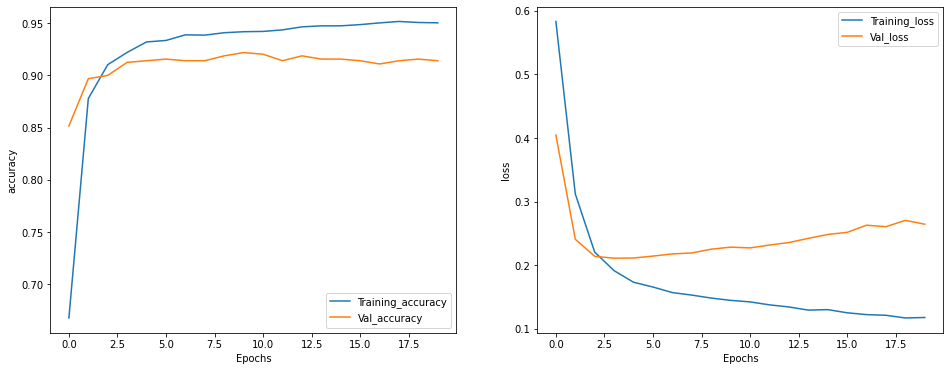

In [39]:
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend(['Training_'+metric, 'Val_'+metric])
  plt.savefig('rnn_loss_curve.png')

plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')

In [40]:
hypermodel = tuner.hypermodel.build(best_hps)
hypermodel.fit(training_dataset, epochs=best_epoch , validation_data=val_data, validation_steps=20)

Epoch 1/10
478/478 [==============================] - 8s 13ms/step - loss: 0.5793 - accuracy: 0.6778 - val_loss: 0.4356 - val_accuracy: 0.8438
Epoch 2/10
478/478 [==============================] - 6s 13ms/step - loss: 0.3224 - accuracy: 0.8741 - val_loss: 0.2440 - val_accuracy: 0.8828
Epoch 3/10
478/478 [==============================] - 6s 13ms/step - loss: 0.2193 - accuracy: 0.9064 - val_loss: 0.2128 - val_accuracy: 0.9078
Epoch 4/10
478/478 [==============================] - 6s 13ms/step - loss: 0.1882 - accuracy: 0.9258 - val_loss: 0.2091 - val_accuracy: 0.9062
Epoch 5/10
478/478 [==============================] - 6s 13ms/step - loss: 0.1759 - accuracy: 0.9309 - val_loss: 0.2089 - val_accuracy: 0.9078
Epoch 6/10
478/478 [==============================] - 6s 13ms/step - loss: 0.1671 - accuracy: 0.9338 - val_loss: 0.2125 - val_accuracy: 0.9125
Epoch 7/10
478/478 [==============================] - 6s 12ms/step - loss: 0.1573 - accuracy: 0.9370 - val_loss: 0.2159 - val_accuracy: 0.9141

In [41]:
pickle.dump(hypermodel, open("model_RNN.pkl", 'wb'))

INFO:tensorflow:Assets written to: ram://cc1dc776-b376-4073-aaa4-4644b9ecdd74/assets


In [42]:
eval_result = hypermodel.evaluate(training_dataset)
print("[train loss, train accuracy]:", eval_result)

478/478 [==============================] - 2s 4ms/step - loss: 0.1281 - accuracy: 0.9497
[train loss, train accuracy]: [0.1281406432390213, 0.9497122764587402]


In [43]:
eval_result = hypermodel.evaluate(testing_data)
print("[test loss, test accuracy]:", eval_result)

59/59 [==============================] - 0s 4ms/step - loss: 0.2095 - accuracy: 0.9179
[test loss, test accuracy]: [0.20949454605579376, 0.9179025292396545]



Performance on Test Set

              precision    recall  f1-score   support

           0       0.90      0.91      0.90       796
           1       0.93      0.92      0.93      1092

    accuracy                           0.92      1888
   macro avg       0.92      0.92      0.92      1888
weighted avg       0.92      0.92      0.92      1888





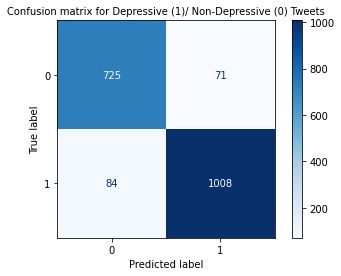

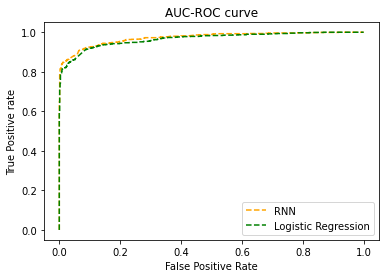

In [44]:
predictions = (hypermodel.predict(X_test['tweet']) > 0.5).astype("int32")

# Classification Report
print("\n\033[1m"+"Performance on Test Set" + "\033[0m\n")
print(classification_report(y_test, predictions))

# Confusion Matrix
print("\n")
cm = confusion_matrix(y_test, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion matrix for Depressive (1)/ Non-Depressive (0) Tweets", size = 10);
plt.savefig('rnn_confusion_m.png')
plt.show()

# AUC-ROC Curve
print("\n")
pred_y_prob = hypermodel.predict(X_test['tweet']).ravel()   
fpr_rnn, tpr_rnn, thresh_rnn = roc_curve(y_test, pred_y_prob)
plt.plot(fpr_rnn, tpr_rnn, linestyle='--',color='orange', label="RNN")
plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label="Logistic Regression")

plt.title("AUC-ROC curve")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('AUC_ROC.png')
plt.show()

**Advanced model -** LSTM

In [45]:
def build_model2(hp):
    hp_units = hp.Int('units',min_value=32,max_value=512,step=32)
    hp_drop_rate = hp.Float('rate', min_value=0, max_value=0.9, step=0.1)
    hp_choice = hp.Choice('activation',values=['relu', 'sigmoid'])

    model = tf.keras.Sequential([encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 32, mask_zero=True),
    tf.keras.layers.SpatialDropout1D(rate = hp_drop_rate),
     tf.keras.layers.LSTM(32),
    tf.keras.layers.Dropout(rate = hp_drop_rate),
    tf.keras.layers.Dense(units=hp_units, activation='relu'),
    tf.keras.layers.Dropout(rate = hp_drop_rate),
    tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
              metrics=['accuracy'])
    return model

tuner = kt.Hyperband(build_model2,
                     objective='val_accuracy',
                     max_epochs=20,
                     factor=3,
                     directory='my_dir2',
                     project_name='intro_to_kt2')

es = EarlyStopping(monitor='val_loss', patience=3, verbose=1)
tuner.search(training_dataset, epochs=50, validation_data=val_data, validation_steps=20, callbacks = [es])

best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

Trial 30 Complete [00h 05m 16s]
val_accuracy: 0.8890625238418579

Best val_accuracy So Far: 0.9281250238418579
Total elapsed time: 00h 36m 46s
INFO:tensorflow:Oracle triggered exit


In [46]:
print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")


The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 192 and the optimal learning rate for the optimizer
is 0.001.



In [47]:
model = tuner.hypermodel.build(best_hps)
history = model.fit(training_dataset, epochs=20, validation_data=val_data, validation_steps=20)

val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Epoch 1/20
478/478 [==============================] - 16s 24ms/step - loss: 0.3966 - accuracy: 0.7943 - val_loss: 0.2103 - val_accuracy: 0.8969
Epoch 2/20
478/478 [==============================] - 10s 22ms/step - loss: 0.2138 - accuracy: 0.9166 - val_loss: 0.2169 - val_accuracy: 0.9172
Epoch 3/20
478/478 [==============================] - 10s 21ms/step - loss: 0.1939 - accuracy: 0.9244 - val_loss: 0.2165 - val_accuracy: 0.9234
Epoch 4/20
478/478 [==============================] - 10s 22ms/step - loss: 0.1885 - accuracy: 0.9268 - val_loss: 0.2235 - val_accuracy: 0.9172
Epoch 5/20
478/478 [==============================] - 10s 21ms/step - loss: 0.1796 - accuracy: 0.9290 - val_loss: 0.2236 - val_accuracy: 0.9172
Epoch 6/20
478/478 [==============================] - 10s 21ms/step - loss: 0.1792 - accuracy: 0.9304 - val_loss: 0.2173 - val_accuracy: 0.9141
Epoch 7/20
478/478 [==============================] - 10s 21ms/step - loss: 0.1764 - accuracy: 0.9319 - val_loss: 0.2224 - val_accuracy:

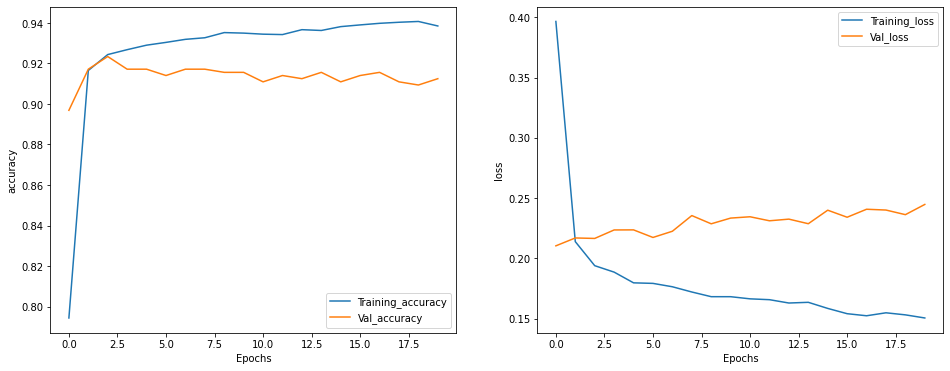

In [48]:
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend(['Training_'+metric, 'Val_'+metric])
  plt.savefig('lstm_loss_curve.png')

plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')

In [49]:
hypermodel = tuner.hypermodel.build(best_hps)
hypermodel.fit(training_dataset, epochs=best_epoch , validation_data=val_data, validation_steps=20)

Epoch 1/3
478/478 [==============================] - 17s 25ms/step - loss: 0.4016 - accuracy: 0.7917 - val_loss: 0.2159 - val_accuracy: 0.8969
Epoch 2/3
478/478 [==============================] - 10s 22ms/step - loss: 0.2170 - accuracy: 0.9132 - val_loss: 0.2106 - val_accuracy: 0.9141
Epoch 3/3
478/478 [==============================] - 10s 22ms/step - loss: 0.1946 - accuracy: 0.9233 - val_loss: 0.2075 - val_accuracy: 0.9187


In [50]:
pickle.dump(hypermodel, open("model_LSTM.pkl", 'wb'))

INFO:tensorflow:Assets written to: ram://54f79f56-b50f-4bee-a0f2-067d0546d35a/assets


INFO:tensorflow:Assets written to: ram://54f79f56-b50f-4bee-a0f2-067d0546d35a/assets


In [51]:
eval_result = hypermodel.evaluate(training_dataset)
print("[train loss, train accuracy]:", eval_result)

478/478 [==============================] - 3s 6ms/step - loss: 0.1547 - accuracy: 0.9385
[train loss, train accuracy]: [0.15466007590293884, 0.9385299682617188]


In [52]:
eval_result = hypermodel.evaluate(testing_data)
print("[test loss, test accuracy]:", eval_result)

59/59 [==============================] - 0s 6ms/step - loss: 0.1900 - accuracy: 0.9206
[test loss, test accuracy]: [0.18995817005634308, 0.9205508232116699]


In [53]:
eval_result = hypermodel.evaluate(val_data)
print("[validation loss, validation accuracy]:", eval_result)

54/54 [==============================] - 0s 6ms/step - loss: 0.2061 - accuracy: 0.9141
[validation loss, validation accuracy]: [0.20613068342208862, 0.9141176342964172]



Performance on Test Set

              precision    recall  f1-score   support

           0       0.89      0.93      0.91       796
           1       0.95      0.91      0.93      1092

    accuracy                           0.92      1888
   macro avg       0.92      0.92      0.92      1888
weighted avg       0.92      0.92      0.92      1888





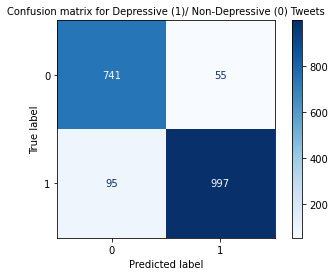

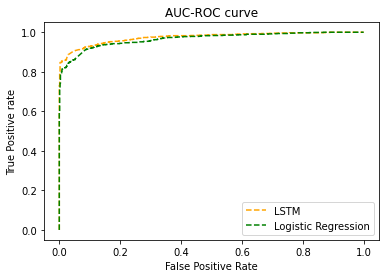

In [54]:
predictions = (hypermodel.predict(X_test['tweet']) > 0.5).astype("int32")

# Classification Report
print("\n\033[1m"+"Performance on Test Set" + "\033[0m\n")
print(classification_report(y_test, predictions))

# Confusion Matrix
print("\n")
cm = confusion_matrix(y_test, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion matrix for Depressive (1)/ Non-Depressive (0) Tweets", size = 10);
plt.savefig('rnn_confusion_m.png')
plt.show()

# AUC-ROC Curve
print("\n")
pred_y_prob = hypermodel.predict(X_test['tweet']).ravel()   
fpr_lstm, tpr_lstm, thresh_lstm = roc_curve(y_test, pred_y_prob)
plt.plot(fpr_lstm, tpr_lstm, linestyle='--',color='orange', label="LSTM")
plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label="Logistic Regression")

plt.title("AUC-ROC curve")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('AUC_ROC.png')
plt.show()

**Advanced model -** CNN

In [55]:
def model_builder(hp):
  hp_units = hp.Int('units', min_value=16, max_value=512, step=32)
  model = tf.keras.Sequential([encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 32, mask_zero=True),
    tf.keras.layers.Conv1D(filters=32, kernel_size=8, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=hp_units, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
  ])
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
  model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
              metrics=['accuracy'])
  return model
  
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=20,
                     factor=3,
                     directory='my_dir',
                     project_name='intro_to_kttp')

es = EarlyStopping(monitor='val_loss', patience=3, verbose=1)
tuner.search(training_dataset, epochs=50, validation_data=val_data, validation_steps=20, callbacks = [es])

best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

Trial 30 Complete [00h 00m 20s]
val_accuracy: 0.901562511920929

Best val_accuracy So Far: 0.917187511920929
Total elapsed time: 00h 11m 23s
INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


In [56]:
print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")


The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 80 and the optimal learning rate for the optimizer
is 0.001.



In [57]:
model = tuner.hypermodel.build(best_hps)
history = model.fit(training_dataset, epochs=20, validation_data=val_data, validation_steps=20)

val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Epoch 1/20
478/478 [==============================] - 4s 7ms/step - loss: 0.3747 - accuracy: 0.8075 - val_loss: 0.2289 - val_accuracy: 0.8984
Epoch 2/20
478/478 [==============================] - 3s 7ms/step - loss: 0.2109 - accuracy: 0.9087 - val_loss: 0.2177 - val_accuracy: 0.9000
Epoch 3/20
478/478 [==============================] - 3s 6ms/step - loss: 0.1840 - accuracy: 0.9154 - val_loss: 0.2274 - val_accuracy: 0.8969
Epoch 4/20
478/478 [==============================] - 3s 6ms/step - loss: 0.1709 - accuracy: 0.9203 - val_loss: 0.2306 - val_accuracy: 0.8953
Epoch 5/20
478/478 [==============================] - 3s 6ms/step - loss: 0.1605 - accuracy: 0.9249 - val_loss: 0.2448 - val_accuracy: 0.9047
Epoch 6/20
478/478 [==============================] - 3s 6ms/step - loss: 0.1512 - accuracy: 0.9300 - val_loss: 0.2402 - val_accuracy: 0.9031
Epoch 7/20
478/478 [==============================] - 3s 6ms/step - loss: 0.1412 - accuracy: 0.9336 - val_loss: 0.2577 - val_accuracy: 0.9078
Epoch 

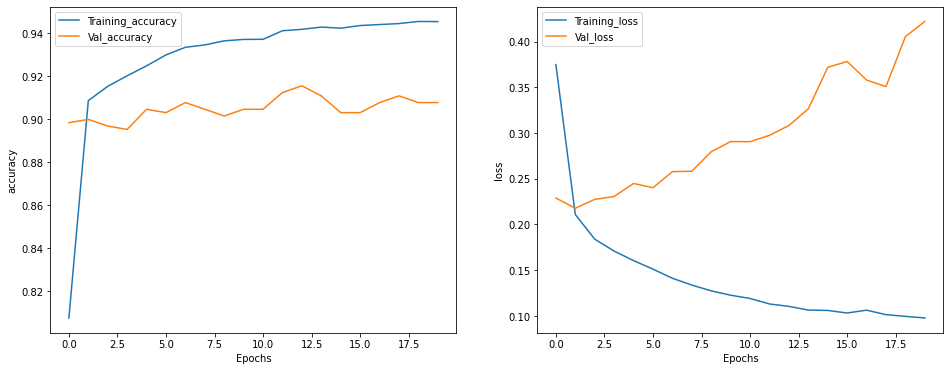

In [58]:
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend(['Training_'+metric, 'Val_'+metric])
  plt.savefig('cnn_loss_curve.png')

plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')

In [59]:
hypermodel = tuner.hypermodel.build(best_hps)
hypermodel.fit(training_dataset, epochs=best_epoch , validation_data=val_data, validation_steps=20)

Epoch 1/13
478/478 [==============================] - 4s 7ms/step - loss: 0.3914 - accuracy: 0.7964 - val_loss: 0.2213 - val_accuracy: 0.8969
Epoch 2/13
478/478 [==============================] - 3s 7ms/step - loss: 0.2038 - accuracy: 0.9110 - val_loss: 0.2144 - val_accuracy: 0.8984
Epoch 3/13
478/478 [==============================] - 3s 7ms/step - loss: 0.1797 - accuracy: 0.9256 - val_loss: 0.2165 - val_accuracy: 0.9109
Epoch 4/13
478/478 [==============================] - 3s 6ms/step - loss: 0.1649 - accuracy: 0.9339 - val_loss: 0.2295 - val_accuracy: 0.9047
Epoch 5/13
478/478 [==============================] - 3s 6ms/step - loss: 0.1502 - accuracy: 0.9396 - val_loss: 0.2480 - val_accuracy: 0.9078
Epoch 6/13
478/478 [==============================] - 3s 7ms/step - loss: 0.1420 - accuracy: 0.9426 - val_loss: 0.2589 - val_accuracy: 0.9094
Epoch 7/13
478/478 [==============================] - 3s 6ms/step - loss: 0.1274 - accuracy: 0.9475 - val_loss: 0.2833 - val_accuracy: 0.9078
Epoch 

In [60]:
pickle.dump(hypermodel, open("model_CNN.pkl", 'wb'))

INFO:tensorflow:Assets written to: ram://77d29edf-6e85-407f-b211-5579eb6ffe6d/assets


INFO:tensorflow:Assets written to: ram://77d29edf-6e85-407f-b211-5579eb6ffe6d/assets


In [61]:
eval_result = hypermodel.evaluate(training_dataset)
print("[train loss, train accuracy]:", eval_result)

478/478 [==============================] - 1s 2ms/step - loss: 0.0819 - accuracy: 0.9640
[train loss, train accuracy]: [0.08185885101556778, 0.9640334844589233]


In [62]:
eval_result = hypermodel.evaluate(testing_data)
print("[test loss, test accuracy]:", eval_result)

59/59 [==============================] - 0s 2ms/step - loss: 0.3189 - accuracy: 0.9073
[test loss, test accuracy]: [0.318915992975235, 0.9073092937469482]



Performance on Test Set

              precision    recall  f1-score   support

           0       0.91      0.87      0.89       796
           1       0.91      0.93      0.92      1092

    accuracy                           0.91      1888
   macro avg       0.91      0.90      0.90      1888
weighted avg       0.91      0.91      0.91      1888





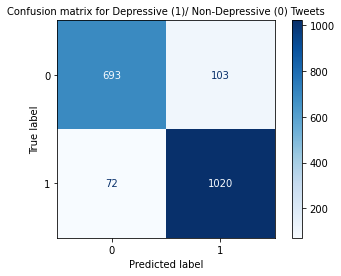

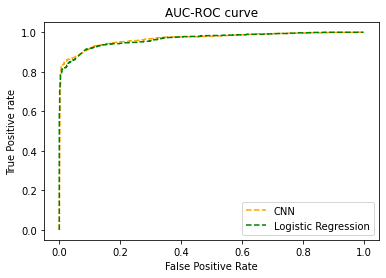

In [63]:
predictions = (hypermodel.predict(X_test['tweet']) > 0.5).astype("int32")

# Classification Report
print("\n\033[1m"+"Performance on Test Set" + "\033[0m\n")
print(classification_report(y_test, predictions))

# Confusion Matrix
print("\n")
cm = confusion_matrix(y_test, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion matrix for Depressive (1)/ Non-Depressive (0) Tweets", size = 10);
plt.savefig('cnn_confusion_m.png')
plt.show()

# AUC-ROC Curve
print("\n")
pred_y_prob = hypermodel.predict(X_test['tweet']).ravel()   
fpr_rnn, tpr_rnn, thresh_rnn = roc_curve(y_test, pred_y_prob)
plt.plot(fpr_rnn, tpr_rnn, linestyle='--',color='orange', label="CNN")
plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label="Logistic Regression")

plt.title("AUC-ROC curve")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('AUC_ROC.png')
plt.show()